## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

import sklearn.model_selection as skl
from itertools import chain
from skimage import io
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix   


from random import sample
from keras.preprocessing.image import ImageDataGenerator

from keras.models import load_model

from keras.optimizers import Adam

from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

2022-12-27 12:50:05.757767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-27 12:50:06.256947: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/vnl/miniconda3/envs/tf/lib/
2022-12-27 12:50:06.257006: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/vnl/miniconda3/envs/tf/lib/
2022-12-27 12:50:06.257010: W tensorflow/compiler/tf2tensorr

## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
78798,00019348_001.png,Effusion|Mass|Pleural_Thickening,1,19348,52,M,PA,2818,2991,0.143000,0.143000,NaN,data/images_009/images/00019348_001.png
25582,00006724_002.png,No Finding,2,6724,23,M,PA,2021,2021,0.194311,0.194311,NaN,data/images_004/images/00006724_002.png
81538,00020043_024.png,Cardiomegaly|Effusion,24,20043,45,F,AP,3056,2544,0.139000,0.139000,NaN,data/images_009/images/00020043_024.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)

all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
55559,00013914_000.png,Atelectasis,0,13914,33,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,0
85526,00021086_000.png,Effusion,0,21086,62,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,0,0
44752,00011504_022.png,No Finding,22,11504,54,M,PA,2500,2048,0.168,...,0,0,0,0,0,1,0,0,0,0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo

all_xray_df['pneumonia_class'] = np.where( all_xray_df.Pneumonia == 1, "positive",  "negative")

## Create your training and testing data:

In [5]:
def create_splits(dataset):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    
    train_data, val_data = skl.train_test_split(dataset, 
                                   test_size = 0.2, 
                                   stratify = dataset['Pneumonia'])
    
    #balance train_data
    p_ind=train_data[train_data['pneumonia_class']=='positive'].index.tolist()
    n_ind=train_data[train_data['pneumonia_class']=='negative'].index.tolist()
    n_sample = sample(n_ind,len(p_ind))
    train_data=train_data.loc[p_ind+n_sample]
    
    vp_ind=val_data[val_data['pneumonia_class']=='positive'].index.tolist()
    vn_ind=val_data[val_data['pneumonia_class']=='negative'].index.tolist()
    vn_sample = sample(vn_ind,4*len(vp_ind))
    val_data=val_data.loc[vp_ind+vn_sample]
    
    
    return train_data, val_data



In [6]:
train_data, val_data = create_splits(all_xray_df)

train_data['Pneumonia'].sum()/len(train_data)

0.5

In [7]:
val_data['Pneumonia'].sum()/len(val_data)

0.2

In [8]:
train_data['Pneumonia'].value_counts()

1    1145
0    1145
Name: Pneumonia, dtype: int64

In [9]:
val_data['Pneumonia'].value_counts()

0    1144
1     286
Name: Pneumonia, dtype: int64

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [10]:
IMG_SIZE = (224, 224)

In [11]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    
    
    idg = ImageDataGenerator( rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    
    return idg


def make_train_gen(train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo
    
    idg = my_image_augmentation()
    
    
    train_gen = idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 64)
    
    return train_gen


def make_val_gen(valid_df):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    

    
    val_idg = ImageDataGenerator(rescale=1. / 255.0)

    
    val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = "binary",
                                         target_size = IMG_SIZE, 
                                         batch_size = 128)
    return val_gen

In [12]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(val_data)


valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


In [13]:
## May want to pull a single large batch of random validation data for testing after each epoch:
train_gen = make_train_gen(train_data)


trainX, trainY = train_gen.next()

Found 2290 validated image filenames belonging to 2 classes.


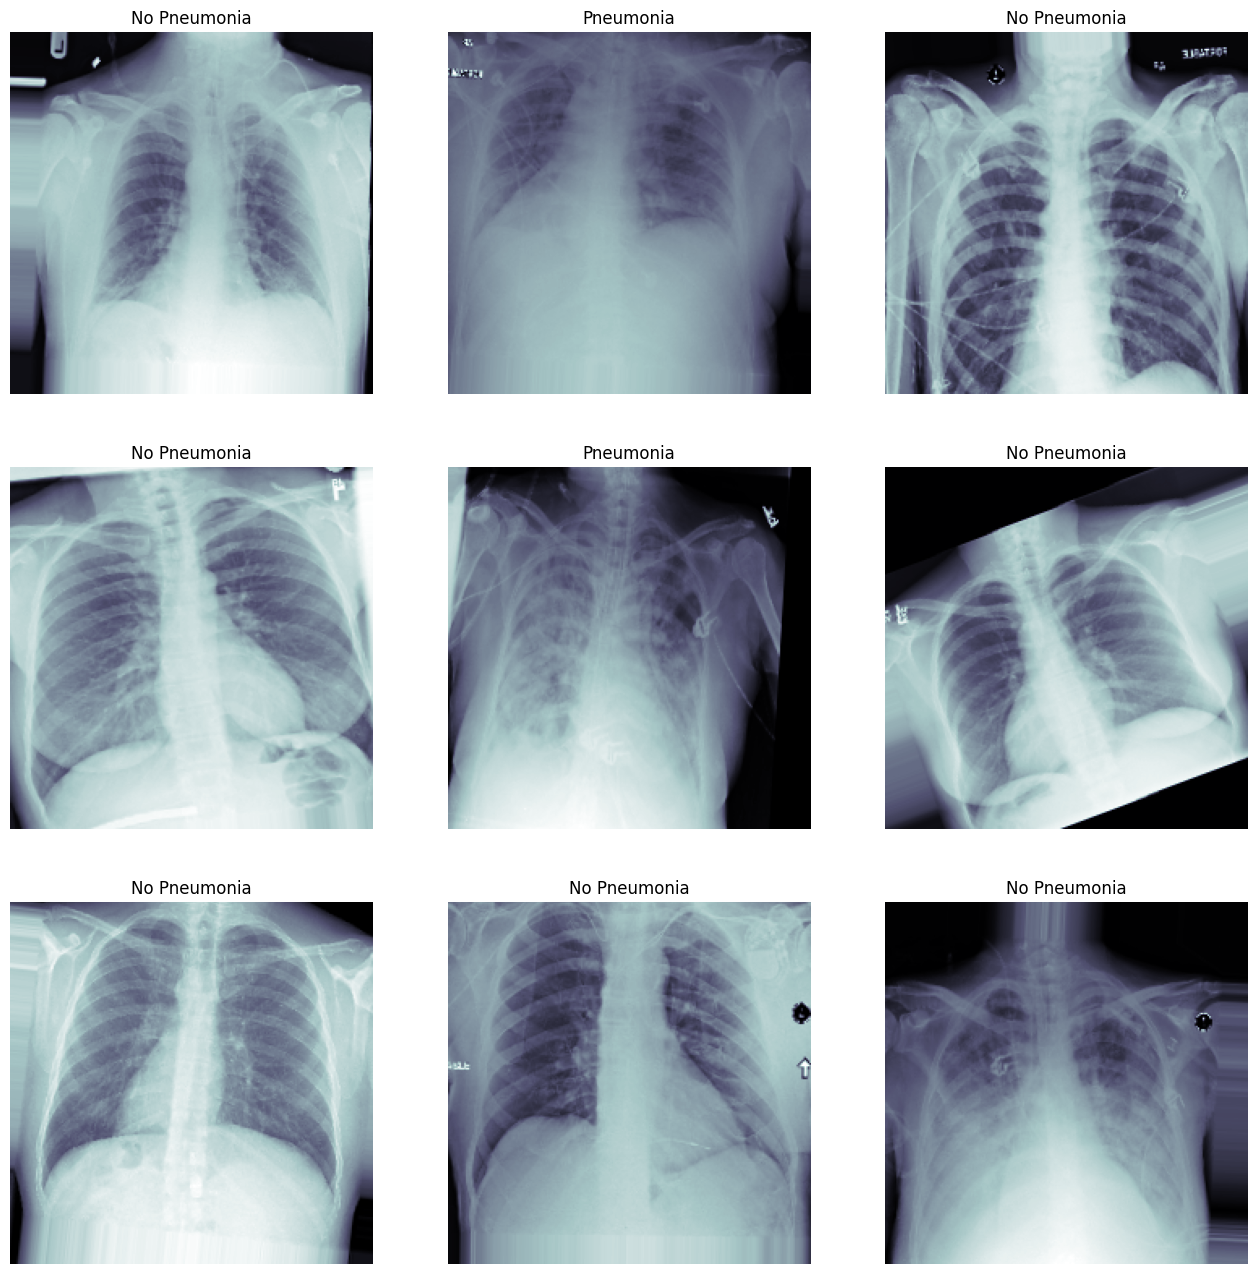

In [14]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(3, 3, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [15]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    
    vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
        
    
    for layer in vgg_model.layers:        
        print(layer.name, layer.trainable)
        
    return vgg_model


In [16]:
def build_my_model(vgg_model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    new_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    new_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    new_model.add(Flatten())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(256, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    new_model.add(Dense(1, activation='sigmoid'))
    
    
    
    return new_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results


In [17]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= "val_loss", # test with [''] 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'auto', 
                             save_weights_only = True)

early = EarlyStopping(monitor= "val_loss", 
                      mode= 'auto', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

In [18]:
vgg_model = load_pretrained_model()

new_model = build_my_model(vgg_model)

2022-12-27 12:50:11.721031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 12:50:11.724542: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 12:50:11.724730: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-27 12:50:11.725084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


2022-12-27 12:50:13.210850: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.


In [19]:
## Set our optimizer, loss function, and learning rate
optimizer = Adam(learning_rate=1e-3)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [20]:
## train your model

# Todo


history = new_model.fit(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 100, 
                          callbacks = callbacks_list)

Epoch 1/100


2022-12-27 12:50:16.356203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-12-27 12:50:16.712329: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-27 12:50:17.527014: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-27 12:50:17.527034: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-27 12:50:18.330834: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate

19/36 [==============>...............] - ETA: 15s - loss: 1.0798 - binary_accuracy: 0.4992

2022-12-27 12:50:39.927201: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.61GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-27 12:50:39.927224: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.61GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-27 12:50:40.017461: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-27 12:50:40.017488: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

36/36 [==============================] - ETA: 0s - loss: 0.9060 - binary_accuracy: 0.5039

2022-12-27 12:50:59.811300: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-12-27 12:50:59.811324: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



Epoch 1: val_loss improved from inf to 0.73142, saving model to xray_class_my_model.best.hdf5
36/36 [==============================] - 49s 1s/step - loss: 0.9060 - binary_accuracy: 0.5039 - val_loss: 0.7314 - val_binary_accuracy: 0.2344
Epoch 2/100
36/36 [==============================] - ETA: 0s - loss: 0.6873 - binary_accuracy: 0.5524
Epoch 2: val_loss improved from 0.73142 to 0.63437, saving model to xray_class_my_model.best.hdf5
36/36 [==============================] - 35s 956ms/step - loss: 0.6873 - binary_accuracy: 0.5524 - val_loss: 0.6344 - val_binary_accuracy: 0.5781
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 0.6883 - binary_accuracy: 0.5393
Epoch 3: val_loss improved from 0.63437 to 0.60676, saving model to xray_class_my_model.best.hdf5
36/36 [==============================] - 34s 946ms/step - loss: 0.6883 - binary_accuracy: 0.5393 - val_loss: 0.6068 - val_binary_accuracy: 0.6641
Epoch 4/100
36/36 [==============================] - ETA: 0s - loss: 0

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [21]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
new_model.load_weights(weight_path)
pred_Y = new_model.predict(val_gen, batch_size = 64, verbose = True)

2022-12-27 12:59:07.954919: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


12/12 [==============================] - 25s 1s/step


In [22]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
    return

    
#Also consider plotting the history of your model training:

# Define a function here that will plot loss, val_loss, binary_accuracy, and val_binary_accuracy over all of 
# your epochs: 

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    return

def plot_precision_recall_curve(t_y, p_y):
    precision, recall, threshold = precision_recall_curve(t_y,p_y,pos_label = 1)
    threshold = np.append(threshold, 1)
    plt.style.use('ggplot')
    plt.plot(precision, recall)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.show()
    
    return precision, recall, threshold

def plot_f1(t_y,p_y):
    precision, recall, threshold = plot_precision_recall_curve(t_y,p_y)
    f1 = 2*(precision*recall)/(precision+recall)
    plt.style.use('ggplot')
    plt.plot(threshold, f1)
    plt.title('F1 vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1')
    plt.show()
    
    return precision, recall, f1, threshold

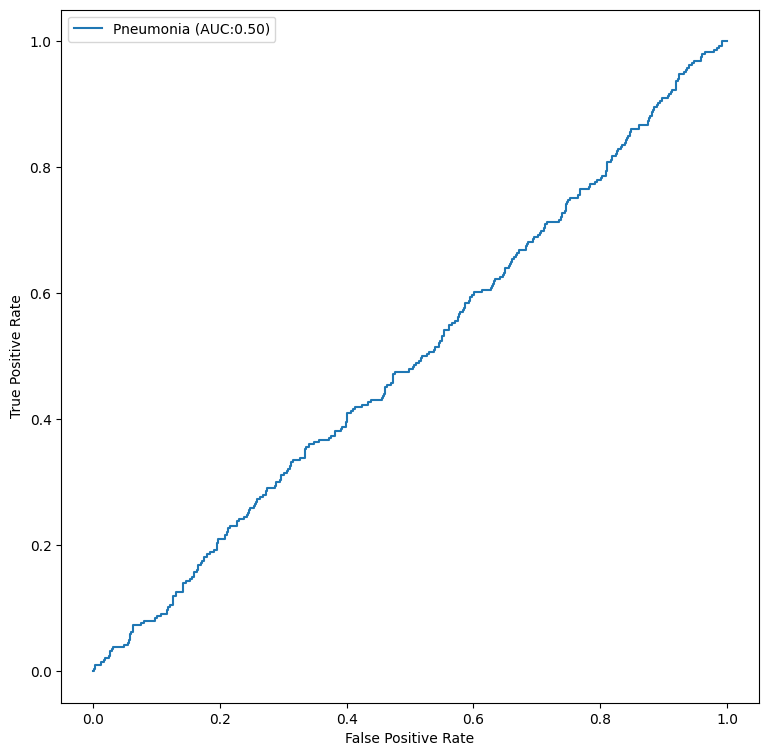

In [23]:
plot_auc(val_data['Pneumonia'].values, pred_Y)

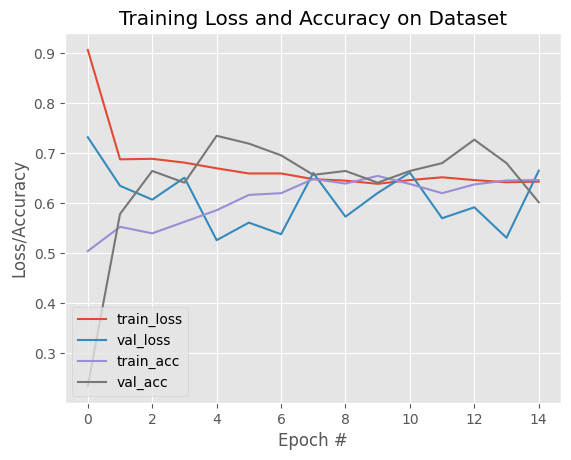

In [24]:
## plot figures
plot_history(history)
# Todo

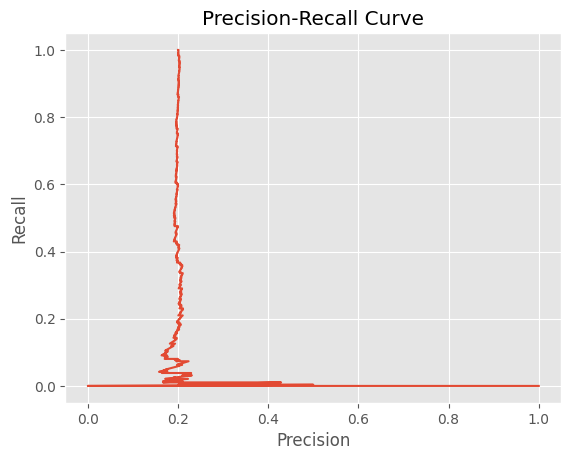

/tmp/ipykernel_34255/3099924484.py:50: RuntimeWarning: invalid value encountered in divide
  f1 = 2*(precision*recall)/(precision+recall)


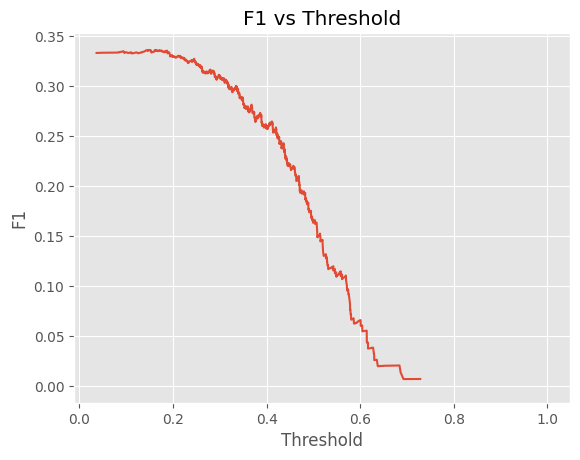

In [25]:
precision, recall, f1, thresholds_f1 = plot_f1(val_data['Pneumonia'].values, pred_Y)


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [26]:
def find_F1_thresh(f1,thresh):
    df = pd.DataFrame({'f1':f1,'threshold':thresh})
    threshmax = df['threshold'][df['f1']==df['f1'].max()] .iloc[-1]
    return threshmax

In [27]:
thresh_F1 = find_F1_thresh(f1, thresholds_f1)
print("Maximium F1-score is {} \nThreshhold for this F1-score is {}".format(str(np.max(f1)), str(thresh_F1)))

Maximium F1-score is nan 
Threshhold for this F1-score is 0.16171887516975403


In [28]:
val_filenames = np.array(val_gen.filenames)
val_labels=np.array(val_gen.labels)

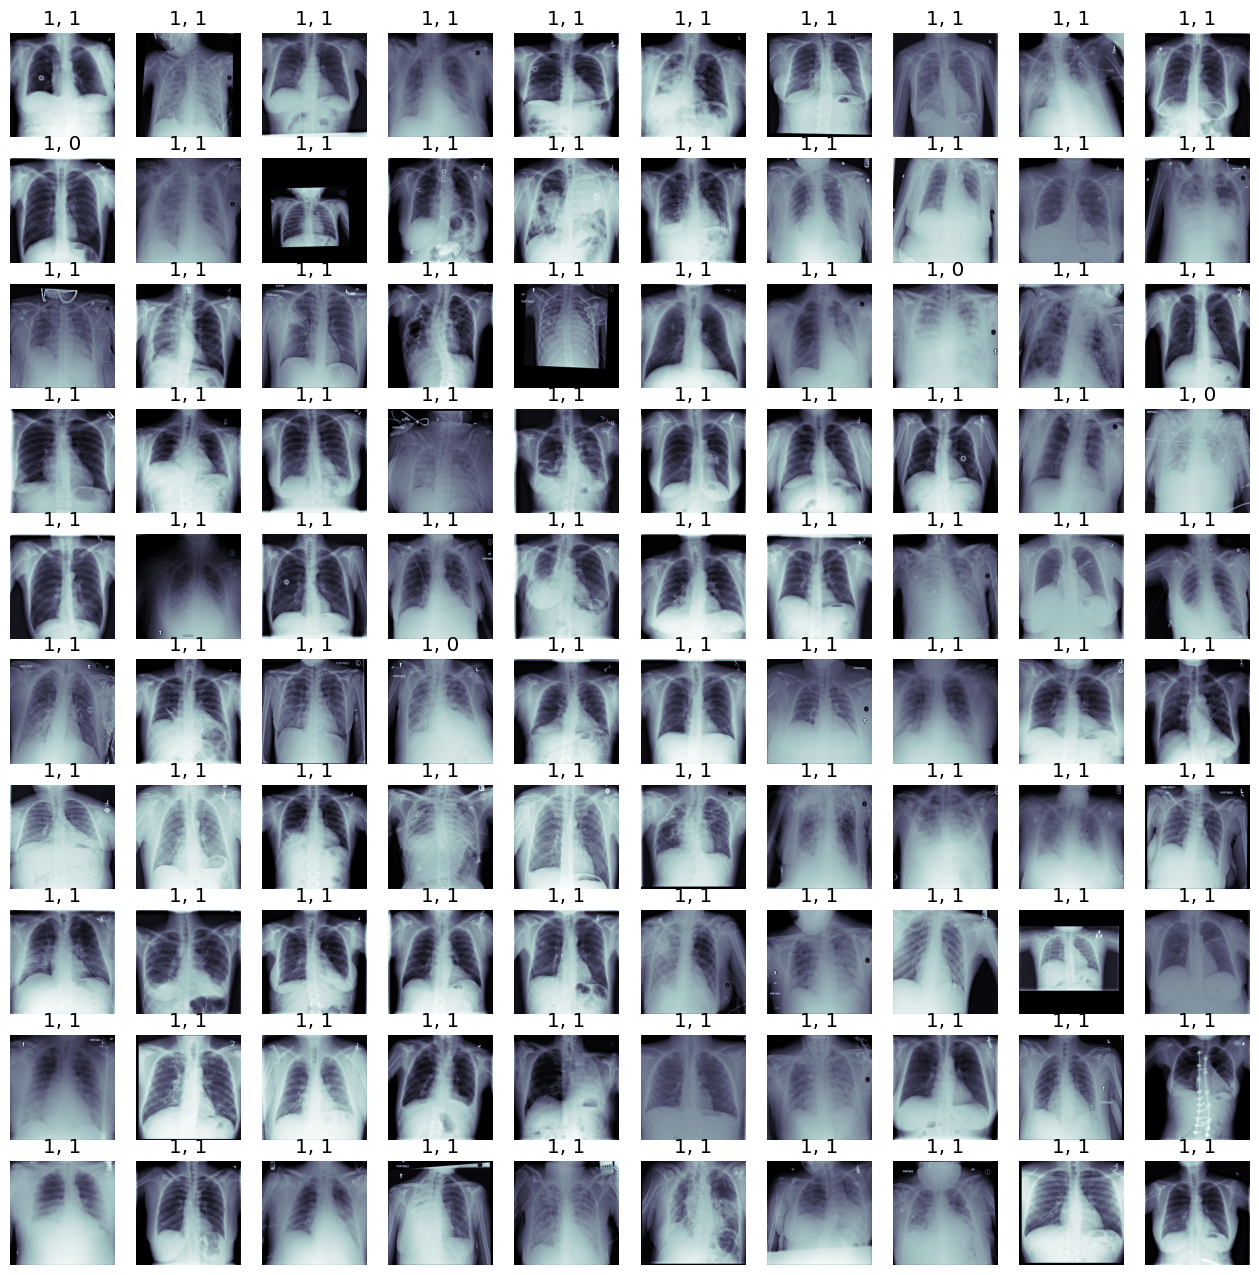

In [29]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo
YOUR_THRESHOLD = thresh_F1

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0


for (c_x, c_y, c_ax) in zip(val_filenames[0:100], val_labels[0:100], m_axs.flatten()):
    c_ax.imshow(io.imread(c_x), cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [30]:
thresh_recall = thresh_F1

pred_Yrecall = []

for x in range(len(pred_Y)):
    if pred_Y[x] > thresh_recall:
        pred_Yrecall.append(1)
    else:
        pred_Yrecall.append(0)

tn,fp,fn,tp = confusion_matrix(val_gen.labels,pred_Yrecall).ravel()
print (tp, fp,"\n",fn,tn)

276 1084 
 10 60


In [31]:
precision = tp / (tp+fp)
precision

0.20294117647058824

In [32]:
recall = tp / (tp+fn)
recall

0.965034965034965

In [33]:
2*(precision*recall)/(precision+recall)

0.3353584447144593

In [34]:
## Just save model architecture to a .json:

model_json = new_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)